In [ ]:
import torch
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

# Adat exploráció

In [ ]:
titanic_csv_url = 'https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/titanic.csv'
titanic_data = pd.read_csv(titanic_csv_url)
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
titanic_data = titanic_data.drop(['Name', 'Ticket', 'SibSp', 'Cabin', 'Parch', 'PassengerId'], axis=1)

In [ ]:
titanic_data['Sex'] = (titanic_data['Sex'] == 'male').astype(np.float32)

titanic_data['Upper_class'] = (titanic_data['Pclass'] == 1).astype(np.float32)
titanic_data['Middle_class'] = (titanic_data['Pclass'] == 2).astype(np.float32)
titanic_data['Lower_class'] = (titanic_data['Pclass'] == 3).astype(np.float32)

titanic_data['Cherbourg_port'] = (titanic_data['Embarked'] == 'C').astype(np.float32)
titanic_data['Queenstown_port'] = (titanic_data['Embarked'] == 'Q').astype(np.float32)
titanic_data['Southampton_port'] = (titanic_data['Embarked'] == 'S').astype(np.float32)

age = np.array(titanic_data['Age'])
age_mean = age[~np.isnan(age)].mean()
age[np.isnan(age)] = age_mean
titanic_data['Age'] = age

In [ ]:
titanic_data = titanic_data.drop(['Embarked'], axis=1)

<ipython-input-6-05a2019d7fdc>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = titanic_data.corr()


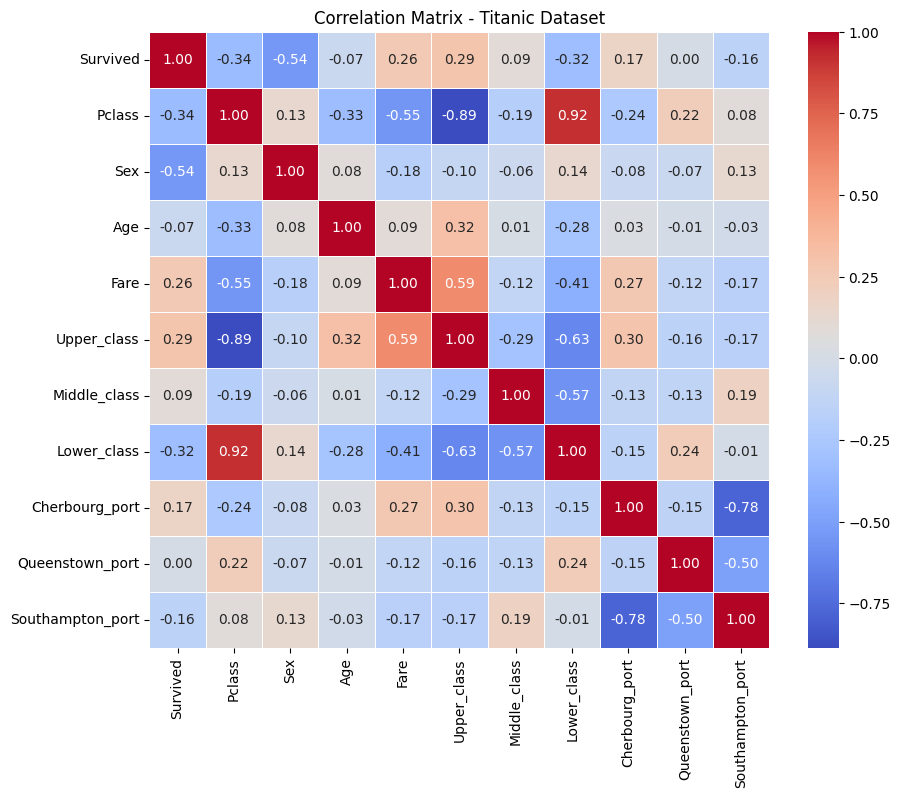

In [ ]:
correlation_matrix = titanic_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Titanic Dataset')
plt.show()

In [ ]:
titanic_data = titanic_data.drop(['Pclass'], axis=1)

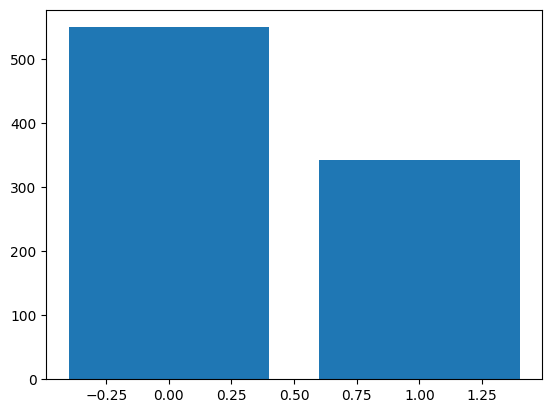

In [ ]:
survived_ids, survived_count = np.unique(titanic_data['Survived'], return_counts=True)
plt.bar(survived_ids, survived_count)
plt.show()

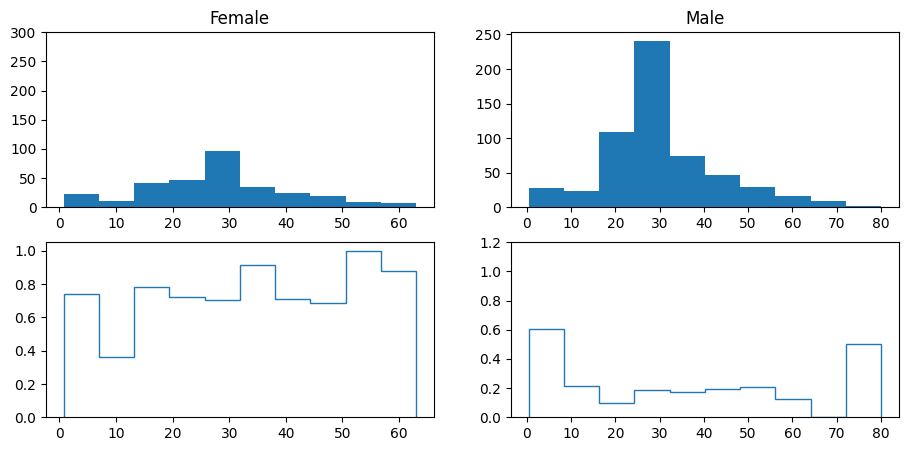

In [ ]:
figure, axes = plt.subplots(2, 2, sharey=False, figsize=(11,5))
counts, bins = np.histogram(titanic_data['Age'][titanic_data['Sex'] == 0])
axes[0,0].stairs(counts, bins, fill=True)
axes[0,0].set_title('Female')

sum_survived, _ = np.histogram(titanic_data['Age'][titanic_data['Sex'] == 0], bins, weights=titanic_data['Survived'][titanic_data['Sex'] == 0])
survived_ratio = sum_survived / counts
axes[1,0].stairs(survived_ratio, bins)

counts, bins = np.histogram(titanic_data['Age'][titanic_data['Sex'] == 1])
axes[0,1].stairs(counts, bins, fill=True)
axes[0,1].set_title('Male')
axes[0,0].set_yticks(axes[0,1].get_yticks())

sum_survived, _ = np.histogram(titanic_data['Age'][titanic_data['Sex'] == 1], bins, weights=titanic_data['Survived'][titanic_data['Sex'] == 1])
survived_ratio = sum_survived / counts
axes[1,1].stairs(survived_ratio, bins)
axes[1,1].set_yticks(axes[1,0].get_yticks())

figure.show()

# Bináris klasszifikációs neurális háló tanítása

In [ ]:
def train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, delta=0.01, patience=10):
  train_losses = []
  val_losses = []

  best_loss = np.inf
  no_improvement_count = 0

  for epoch in range(n_epochs):
    model.train()
    train_epoch_losses = []

    for x, y in train_dataloader:
      optimizer.zero_grad()
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      train_epoch_losses.append(loss)
      loss.backward()
      optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()
    train_losses.append(avg_epoch_loss)

    model.eval()
    val_epoch_losses = []

    for x, y in val_dataloader:
      with torch.no_grad():
        y_hat = model(x)

      loss = loss_fn(y_hat, y)
      val_epoch_losses.append(loss)

    val_epoch_losses = torch.tensor(val_epoch_losses)
    avg_epoch_loss = val_epoch_losses.mean()
    val_losses.append(avg_epoch_loss)

    if avg_epoch_loss + delta < best_loss:
      best_loss = avg_epoch_loss
      no_improvement_count = 0
      torch.save(model.state_dict(), 'best_model.pth')
    else:
      no_improvement_count += 1

    print(f'Tranining {epoch+1}/{n_epochs} done, training loss: {train_losses[-1]}, validation loss: {val_losses[-1]}')

    if no_improvement_count >= patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', best_loss.item())
      return train_losses, val_losses

  return train_losses, val_losses

In [ ]:
features = titanic_data.drop(['Survived'], axis=1)
target = titanic_data['Survived']

x_train, x_rest, y_train, y_rest = train_test_split(features.values, target.values, train_size=0.7, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42)

class TitanicDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)[:,None]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

train_dataset = TitanicDataset(x_train, y_train)
val_dataset = TitanicDataset(x_val, y_val)
test_dataset = TitanicDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


print(train_dataset[11])

(tensor([ 1., 39., 13.,  0.,  1.,  0.,  0.,  0.,  1.]), tensor([0.]))


In [ ]:
class ClassificationModel(nn.Module):
  def __init__(self, input_dim):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 3),
            nn.ReLU(),
            nn.Linear(3,1)
        )
        self.sigmoid = nn.Sigmoid()

  def forward(self, x):
      out = self.linear_relu_layers(x)
      out = self.sigmoid(out)
      return out

In [ ]:
n_epochs = 120
model = ClassificationModel(train_dataset[0][0].shape[0])
loss_fn = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=n_epochs, delta=0.001, patience=20)

Tranining 1/120 done, training loss: 0.8156253695487976, validation loss: 0.7280598282814026
Tranining 2/120 done, training loss: 0.7647971510887146, validation loss: 0.7209975123405457
Tranining 3/120 done, training loss: 0.7569416761398315, validation loss: 0.7173678874969482
Tranining 4/120 done, training loss: 0.7494457960128784, validation loss: 0.7020567059516907
Tranining 5/120 done, training loss: 0.7425104379653931, validation loss: 0.7077191472053528
Tranining 6/120 done, training loss: 0.7352350950241089, validation loss: 0.7005192041397095
Tranining 7/120 done, training loss: 0.7285540699958801, validation loss: 0.6944825053215027
Tranining 8/120 done, training loss: 0.7228699922561646, validation loss: 0.6921250820159912
Tranining 9/120 done, training loss: 0.7169749736785889, validation loss: 0.6851246953010559
Tranining 10/120 done, training loss: 0.7105634212493896, validation loss: 0.6786649227142334
Tranining 11/120 done, training loss: 0.7050560712814331, validation 

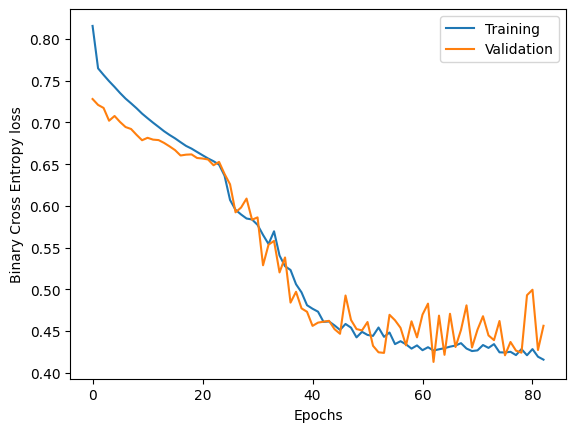

In [ ]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy loss')
plt.legend()
plt.show()

In [ ]:
x_train_min = np.min(x_train, axis=0)
x_train_max = np.max(x_train, axis=0)

x_train = (x_train - x_train_min) / (x_train_max - x_train_min)
x_val = (x_val - x_train_min) / (x_train_max - x_train_min)
x_test = (x_test - x_train_min) / (x_train_max - x_train_min)

train_dataset = TitanicDataset(x_train, y_train)
val_dataset = TitanicDataset(x_val, y_val)
test_dataset = TitanicDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
n_epochs = 120
model = ClassificationModel(train_dataset[0][0].shape[0])
loss_fn = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=n_epochs)

Tranining 1/120 done, training loss: 0.7620553970336914, validation loss: 0.7268270254135132
Tranining 2/120 done, training loss: 0.7443289756774902, validation loss: 0.7032313346862793
Tranining 3/120 done, training loss: 0.7289858460426331, validation loss: 0.6956349015235901
Tranining 4/120 done, training loss: 0.715003252029419, validation loss: 0.6894591450691223
Tranining 5/120 done, training loss: 0.6965559720993042, validation loss: 0.6733790040016174
Tranining 6/120 done, training loss: 0.6789445877075195, validation loss: 0.6542572379112244
Tranining 7/120 done, training loss: 0.6632789969444275, validation loss: 0.6267507672309875
Tranining 8/120 done, training loss: 0.644179105758667, validation loss: 0.609673261642456
Tranining 9/120 done, training loss: 0.6235448122024536, validation loss: 0.5890921354293823
Tranining 10/120 done, training loss: 0.6018675565719604, validation loss: 0.5529454946517944
Tranining 11/120 done, training loss: 0.5639521479606628, validation los

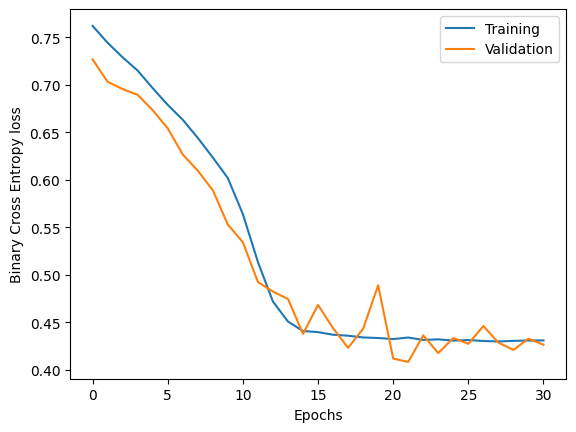

In [ ]:
plt.plot(train_losses, label='Training')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
accuracy = []
prediction_label_pairs = []
for x, y in test_dataloader:
    with torch.no_grad():
      y_hat = model(x)
    prediction = torch.round(y_hat)
    prediction_label_pairs.append(torch.concat((prediction, y), dim=-1))
    accuracy.append((prediction == y).to(torch.float32))

accuracy = torch.cat(accuracy).mean()
print('Accuracy: ', accuracy.item())
print(prediction_label_pairs[0])

Accuracy:  0.7835820913314819
tensor([[0., 0.],
        [0., 0.],
        [1., 1.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [1., 0.],
        [1., 1.],
        [1., 0.],
        [0., 0.],
        [0., 0.],
        [1., 1.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])


# Multi klassz klasszifikációs neurális háló tanítása

In [ ]:
glass_csv_url = 'https://nipg12.inf.elte.hu/~vavsaai@nipg.lab/annbsc24_p1/files/glass.csv'
glass_data = pd.read_csv(glass_csv_url)
glass_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


In [ ]:
glass_data.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [ ]:
features = glass_data.drop(['Type'], axis=1)
target = glass_data['Type'].values.copy()
classes = np.unique(target)
n_class = classes.shape[0]
print(classes)
target[target == 7] = 4
target = np.eye(n_class)[target - 1]

x_train, x_rest, y_train, y_rest = train_test_split(features.values, target, train_size=0.7, random_state=4)
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=4)

x_train_min = np.min(x_train, axis=0)
x_train_max = np.max(x_train, axis=0)

x_train = (x_train - x_train_min) / (x_train_max - x_train_min)
x_val = (x_val - x_train_min) / (x_train_max - x_train_min)
x_test = (x_test - x_train_min) / (x_train_max - x_train_min)

class GlassDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

train_dataset = GlassDataset(x_train, y_train)
val_dataset = GlassDataset(x_val, y_val)
test_dataset = GlassDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)


print(train_dataset[11])

[1 2 3 5 6 7]
(tensor([0.2118, 0.5316, 0.7572, 0.3382, 0.5363, 0.0950, 0.2686, 0.0000, 0.0000]), tensor([0., 0., 1., 0., 0., 0.]))


In [ ]:
class MCClassificationModel(nn.Module):
  def __init__(self, input_dim, n_class):
        super().__init__()
        self.linear_relu_layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(8,n_class)
        )

  def forward(self, x):
      out = self.linear_relu_layers(x)
      return out

In [ ]:
class Callback():
  def __init__(self):
    pass

  def on_train_end(self, avg_train_loss):
    pass

  def on_val_end(self, avg_val_loss):
    pass

  def on_test_end(self, avg_test_loss):
    pass

  def on_epoch_end(self, trainer):
    pass

  def on_train_prediction(self, prediction, label):
    pass

  def on_val_prediction(self, prediction, label):
    pass

  def on_test_prediction(self, prediction, label):
    pass

  def on_stop(self, results):
    pass

class EarlyStoppingCallback(Callback):
  def __init__(self, delta=0.01, patience=10, save_path=None, model=None):
    self.delta = delta
    self.patience = patience
    self.best_loss = np.inf
    self.no_improvement_count = 0
    self.save_path = save_path
    self.model = model

  def on_val_end(self, avg_val_loss):
    if avg_val_loss + self.delta < self.best_loss:
      self.best_loss = avg_val_loss
      self.no_improvement_count = 0
      if self.save_path is not None and self.model is not None:
        torch.save(self.model.state_dict(), self.save_path)
    else:
      self.no_improvement_count += 1

  def on_epoch_end(self, trainer):
    if self.no_improvement_count >= self.patience:
      print('Stopped by early stopping.')
      print('Best validation loss: ', self.best_loss.item())
      trainer.stop = True

class MetricsCallback(Callback):
  def __init__(self, metrics_to_track):
    self.metrics_to_track = metrics_to_track
    self.__reset()

  def __reset(self):
    self.metrics_temp = dict()
    self.metrics = dict()

  def __add_prediction(self, prediction, label, prefix):
    for metric_name, metric_fn in self.metrics_to_track.items():
      key = f'{prefix}_{metric_name}'
      if key not in self.metrics:
        self.metrics[key] = []
        self.metrics_temp[key] = []

      self.metrics_temp[key].append(metric_fn(prediction, label).reshape(-1))

  def __aggregate_metrics(self, prefix):
    for key in self.metrics_to_track.keys():
      self.metrics[f'{prefix}_{key}'].append(torch.cat(self.metrics_temp[f'{prefix}_{key}']).mean().item())
      self.metrics_temp[f'{prefix}_{key}'] = []

  def on_train_prediction(self, prediction, label):
    self.__add_prediction(prediction, label, 'train')

  def on_val_prediction(self, prediction, label):
    self.__add_prediction(prediction, label, 'val')

  def on_test_prediction(self, prediction, label):
    self.__add_prediction(prediction, label, 'test')

  def on_train_end(self, avg_train_loss):
    self.__aggregate_metrics('train')

  def on_val_end(self, avg_val_loss):
    self.__aggregate_metrics('val')

  def on_test_end(self, avg_test_loss):
    self.__aggregate_metrics('test')

  def on_stop(self, results):
    metrics = {key: np.array(val) for key,val in self.metrics.items()}
    results.update(metrics)
    self.__reset()

class Trainer():
  def __init__(self, model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=10, callbacks=[]):
    self.model = model
    self.train_dataloader = train_dataloader
    self.val_dataloader = val_dataloader
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.n_epochs = n_epochs
    self.stop = False
    self.callbacks = callbacks
    self.train_losses = []
    self.val_losses = []

  def __train(self, dataloader):
    self.model.train()
    train_epoch_losses = []

    for x, y in dataloader:
      self.optimizer.zero_grad()
      y_hat = self.model(x)
      loss = self.loss_fn(y_hat, y)
      [callback.on_train_prediction(y_hat.detach(), y) for callback in self.callbacks]
      train_epoch_losses.append(loss)
      loss.backward()
      self.optimizer.step()

    train_epoch_losses = torch.tensor(train_epoch_losses)
    avg_epoch_loss = train_epoch_losses.mean()

    [callback.on_train_end(avg_epoch_loss) for callback in self.callbacks]

    return avg_epoch_loss

  def __eval(self, dataloader, test=False):
    self.model.eval()
    epoch_losses = []

    for x, y in dataloader:
      with torch.no_grad():
        y_hat = self.model(x)

      loss = self.loss_fn(y_hat, y)
      if test:
        [callback.on_test_prediction(y_hat.detach(), y) for callback in self.callbacks]
      else:
        [callback.on_val_prediction(y_hat.detach(), y) for callback in self.callbacks]

      epoch_losses.append(loss)

    epoch_losses = torch.tensor(epoch_losses)
    avg_epoch_loss = epoch_losses.mean()

    if test:
      [callback.on_test_end(avg_epoch_loss) for callback in self.callbacks]
    else:
      [callback.on_val_end(avg_epoch_loss) for callback in self.callbacks]

    return avg_epoch_loss

  def train(self):
    for epoch in range(self.n_epochs):
      train_loss = self.__train(self.train_dataloader)
      self.train_losses.append(train_loss)
      val_loss = self.__eval(self.val_dataloader, test=False)
      self.val_losses.append(val_loss)

      print(f'Tranining {epoch+1}/{self.n_epochs} done, training loss: {train_loss}, validation loss: {val_loss}')

      [callback.on_epoch_end(self) for callback in self.callbacks]

      if self.stop:
        break

    results = {
        'train_loss': self.train_losses,
        'val_loss': self.val_losses
    }

    [callback.on_stop(results) for callback in self.callbacks]

    return results

  def test(self, test_dataloader):
    test_loss = self.__eval(test_dataloader, test=True)

    results = {
        'test_loss': test_loss
    }

    [callback.on_stop(results) for callback in self.callbacks]

    return results

In [ ]:
n_epochs = 200
model = MCClassificationModel(train_dataset[0][0].shape[0], n_class=n_class)
loss_fn = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def accuracy(pred, label):
  pred = torch.argmax(pred, dim=-1)
  label = torch.argmax(label, dim=-1)

  return (pred == label).to(torch.float32)

metrics = {
    'Accuracy': accuracy
}

earlystopping_callback = EarlyStoppingCallback(delta=0.01, patience=20, save_path='best_model.pth')
metrics_callback = MetricsCallback(metrics)
callbacks = [earlystopping_callback, metrics_callback]
trainer = Trainer(model, train_dataloader, val_dataloader, optimizer, loss_fn, n_epochs=400, callbacks=callbacks)
results = trainer.train()

Tranining 1/400 done, training loss: 1.7866458892822266, validation loss: 1.8116216659545898
Tranining 2/400 done, training loss: 1.774522066116333, validation loss: 1.804417610168457
Tranining 3/400 done, training loss: 1.7696348428726196, validation loss: 1.7939003705978394
Tranining 4/400 done, training loss: 1.7650086879730225, validation loss: 1.7803606986999512
Tranining 5/400 done, training loss: 1.7526588439941406, validation loss: 1.7673159837722778
Tranining 6/400 done, training loss: 1.7414486408233643, validation loss: 1.7471678256988525
Tranining 7/400 done, training loss: 1.7261594533920288, validation loss: 1.725631594657898
Tranining 8/400 done, training loss: 1.712609052658081, validation loss: 1.7014005184173584
Tranining 9/400 done, training loss: 1.6848087310791016, validation loss: 1.6723120212554932
Tranining 10/400 done, training loss: 1.66189706325531, validation loss: 1.6392271518707275
Tranining 11/400 done, training loss: 1.6449146270751953, validation loss: 

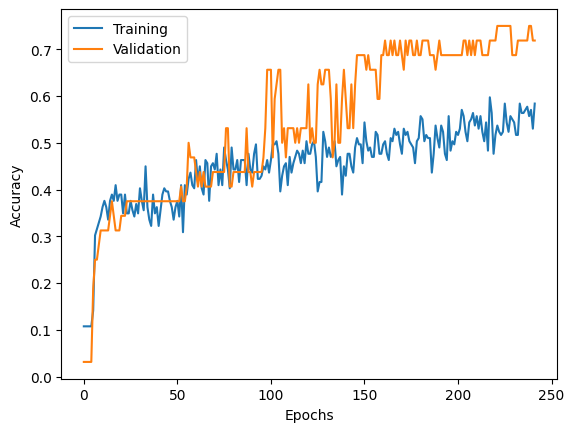

In [ ]:
plt.plot(results['train_Accuracy'], label='Training')
plt.plot(results['val_Accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.eval()
accuracy = []
prediction_label_pairs = []
for x, y in test_dataloader:
    with torch.no_grad():
      y_hat = model(x)
    prediction = torch.argmax(y_hat, dim=1)
    y = torch.argmax(y, dim=1)
    prediction_label_pairs.append(torch.stack((prediction, y), dim=-1))
    accuracy.append((prediction == y).to(torch.float32))

accuracy = torch.cat(accuracy).mean()
print('Accuracy: ', accuracy.item())
print(prediction_label_pairs[0])

print(trainer.test(test_dataloader))

Accuracy:  0.6666666865348816
tensor([[0, 0],
        [1, 4],
        [0, 1],
        [1, 1],
        [3, 3],
        [3, 1],
        [1, 0],
        [0, 0],
        [0, 0],
        [0, 1],
        [1, 1],
        [0, 0],
        [0, 0],
        [1, 1],
        [0, 0],
        [3, 3]])
{'test_loss': tensor(0.9499), 'test_Accuracy': array([0.66666669])}


In [ ]:
from sklearn.metrics import confusion_matrix

prediction_label_pairs = torch.cat(prediction_label_pairs, 0)
print(prediction_label_pairs.shape)
conf = confusion_matrix(prediction_label_pairs[:,1], prediction_label_pairs[:,0])

torch.Size([33, 2])


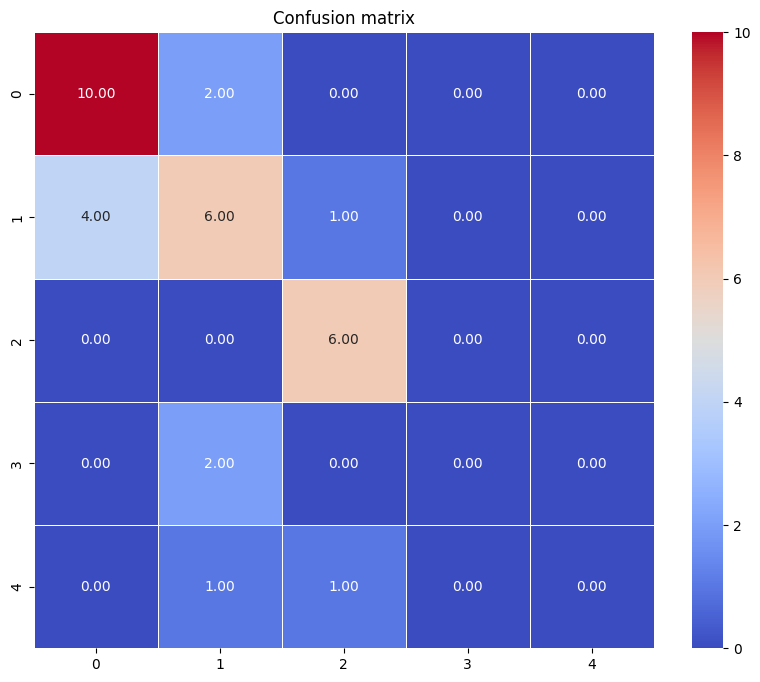

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Confusion matrix')
plt.show()